# **Spotify Songs - Data Mining**

##I downloaded the data about Spotify songs from [Kaggel](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs/data).  

### In this project, I aimed to explore different music genres and their popularity based on the number of plays. I analyzed the top genres of each decade, trends in song features over time, and the most popular rock artists.

### Additionally, I investigated whether there was a correlation between a song’s popularity and its features. Since no significant correlation was found, I decided to review a correlation matrix and focus on explaining the relationship between loudness and energy in songs.

In [ ]:
!pip install fastcluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import r2_score

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Spotify Data Mining/spotify_songs.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 3.2 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


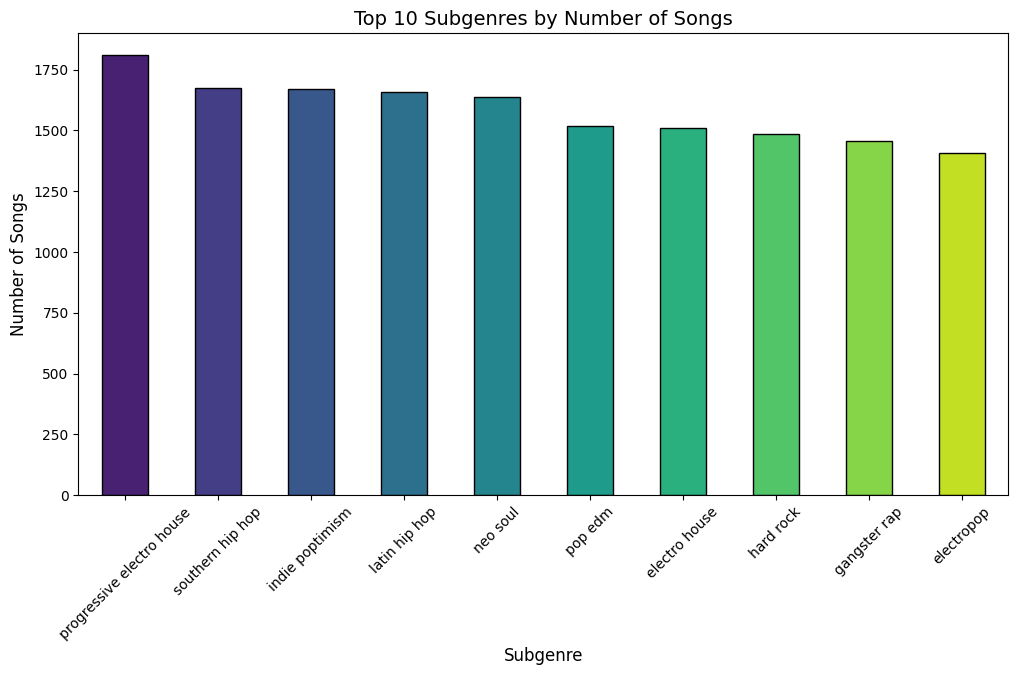

In [ ]:
# Count the number of songs in each subgenre (Top 10)
subgenre_counts = df['playlist_subgenre'].value_counts().head(10)

# colors of the column
colors = sns.color_palette("viridis", len(subgenre_counts))

# Create the bar plot
plt.figure(figsize=(12, 6))
subgenre_counts.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Top 10 Subgenres by Number of Songs', fontsize=14)
plt.xlabel('Subgenre', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()

     decade          playlist_subgenre  count
0    1950.0               classic rock      1
3    1960.0               classic rock     60
11   1970.0               classic rock    229
20   1980.0                 album rock    202
49   1990.0             new jack swing    462
76   2000.0           southern hip hop    385
97   2010.0  progressive electro house   1617
112  2020.0            indie poptimism     99


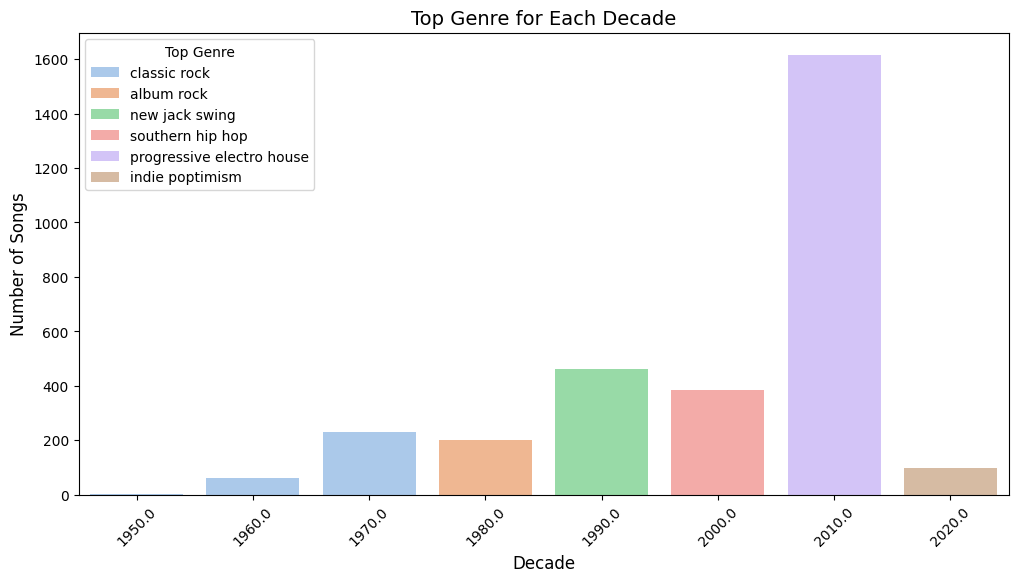

In [ ]:
# Convert release date to datetime format
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')

# Extract the decade
df['decade'] = (df['track_album_release_date'].dt.year // 10) * 10

# Count the number of songs for each genre per decade - group by
genre_counts = df.groupby(['decade', 'playlist_subgenre']).size().reset_index(name='count')

# Find the top genre for each decade - group by
top_genres = genre_counts.loc[genre_counts.groupby('decade')['count'].idxmax()]


# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='decade', y='count', hue='playlist_subgenre', data=top_genres, palette="pastel")
plt.title('Top Genre for Each Decade', fontsize=14)
plt.xlabel('Decade', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Top Genre")

# prints
print(top_genres)
plt.show()

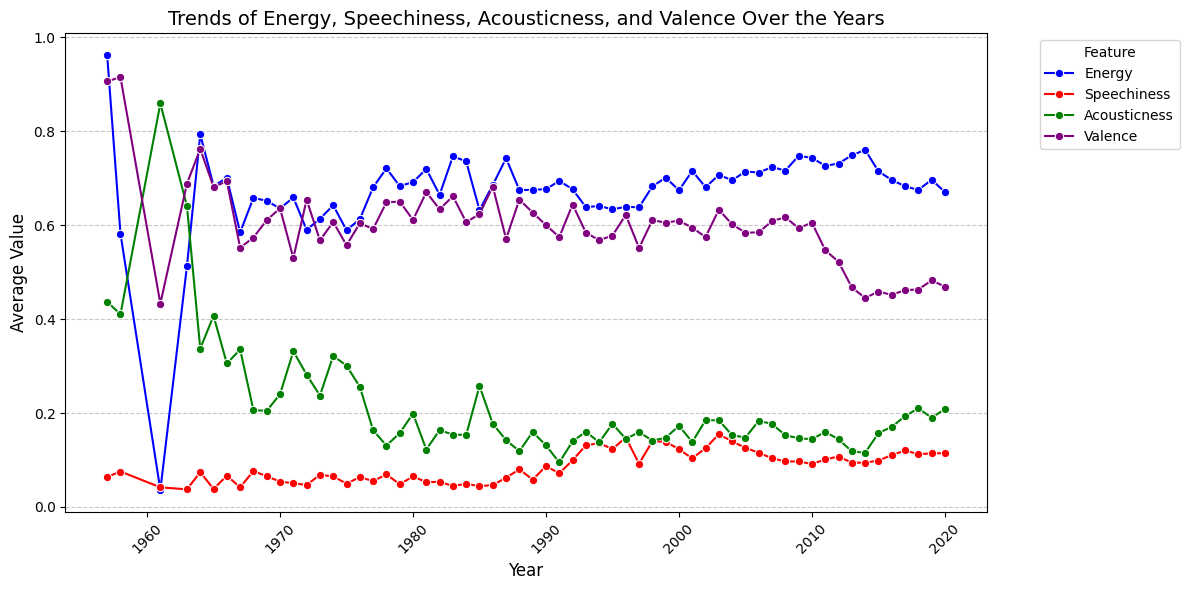

In [ ]:
# Extract the release year
df['year'] = df['track_album_release_date'].dt.year

# Group by year and calculate the average for each feature
energy_trends = df.groupby('year')['energy'].mean().reset_index()
speechiness_trends = df.groupby('year')['speechiness'].mean().reset_index()
acousticness_trends = df.groupby('year')['acousticness'].mean().reset_index()
valence_trends = df.groupby('year')['valence'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='energy', data=energy_trends, label='Energy', color='blue', marker='o')
sns.lineplot(x='year', y='speechiness', data=speechiness_trends, label='Speechiness', color='red', marker='o')
sns.lineplot(x='year', y='acousticness', data=acousticness_trends, label='Acousticness', color='green', marker='o')
sns.lineplot(x='year', y='valence', data=valence_trends, label='Valence', color='purple', marker='o')
plt.title('Trends of Energy, Speechiness, Acousticness, and Valence Over the Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Move the legend to the side
plt.legend(title="Feature", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

<ipython-input-72-91c1a3029c12>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='track_popularity', y='track_artist', data=top_10_artists, palette='viridis')


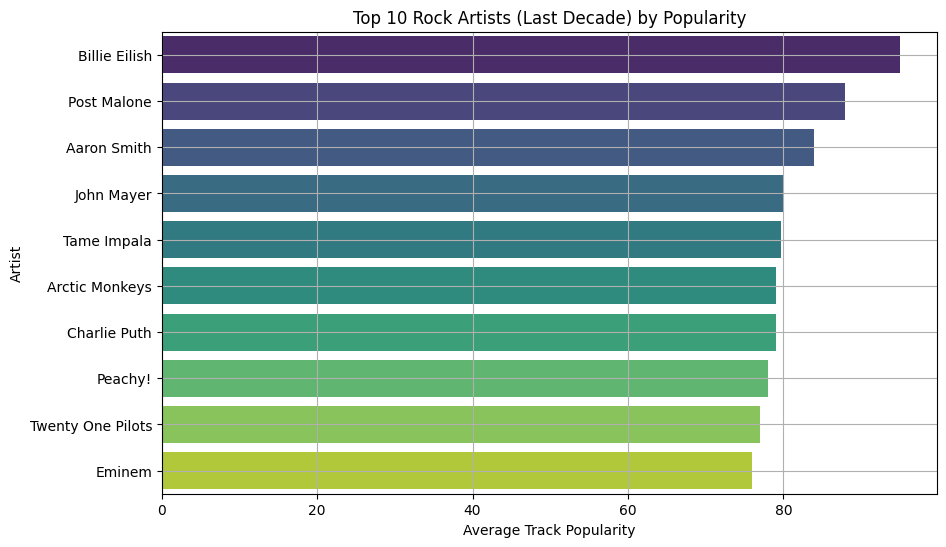

In [ ]:
# Filter the data for rock genre and the last decade
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'])
df['release_year'] = df['track_album_release_date'].dt.year
last_decade_df = df[(df['release_year'] >= 2013) & (df['playlist_genre'] == 'rock')]

# Group by artist and calculate the average popularity
artist_popularity = last_decade_df.groupby('track_artist')['track_popularity'].mean().reset_index()

# Sort by popularity (decending) and select the top 10 artists
top_10_artists = artist_popularity.sort_values(by='track_popularity', ascending=False).head(10)

# Plot the distribution of the top 10 artists
plt.figure(figsize=(10, 6))
sns.barplot(x='track_popularity', y='track_artist', data=top_10_artists, palette='viridis')
plt.title('Top 10 Rock Artists (Last Decade) by Popularity')
plt.xlabel('Average Track Popularity')
plt.ylabel('Artist')
plt.grid(True)
plt.show()

In [ ]:
# Selecting independent variables (musical features) and the dependent variable (popularity)
X = df[['energy', 'danceability', 'tempo', 'speechiness', 'acousticness', 'loudness', 'valence', 'duration_ms']]
y = df['track_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
b0 = model.intercept_
betas = model.coef_

# Displaying the results
print(f"Intercept (b0): {b0:.2f}\n")


feature_importance = pd.DataFrame({'Feature': X.columns, 'Beta': betas})
print(feature_importance)
# Calculating R^2
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Intercept (b0): 83.09

        Feature       Beta
0        energy -35.013714
1  danceability   3.068464
2         tempo   0.017681
3   speechiness  -5.631974
4  acousticness   2.869402
5      loudness   1.835988
6       valence   5.374179
7   duration_ms  -0.000047
R² Score: 0.0601


# The low ${R^2}$ score indicates that the selected musical features (energy, danceability, tempo, speechiness, acousticness, loudness, valence, and duration) do not effectively explain track popularity. This suggests that other factors, such as artist popularity, playlist placements, marketing, and social media presence, might have a stronger influence on a song’s success.
# To improve the model, we should explore non-linear methods, test feature interactions, or incorporate external data sources.

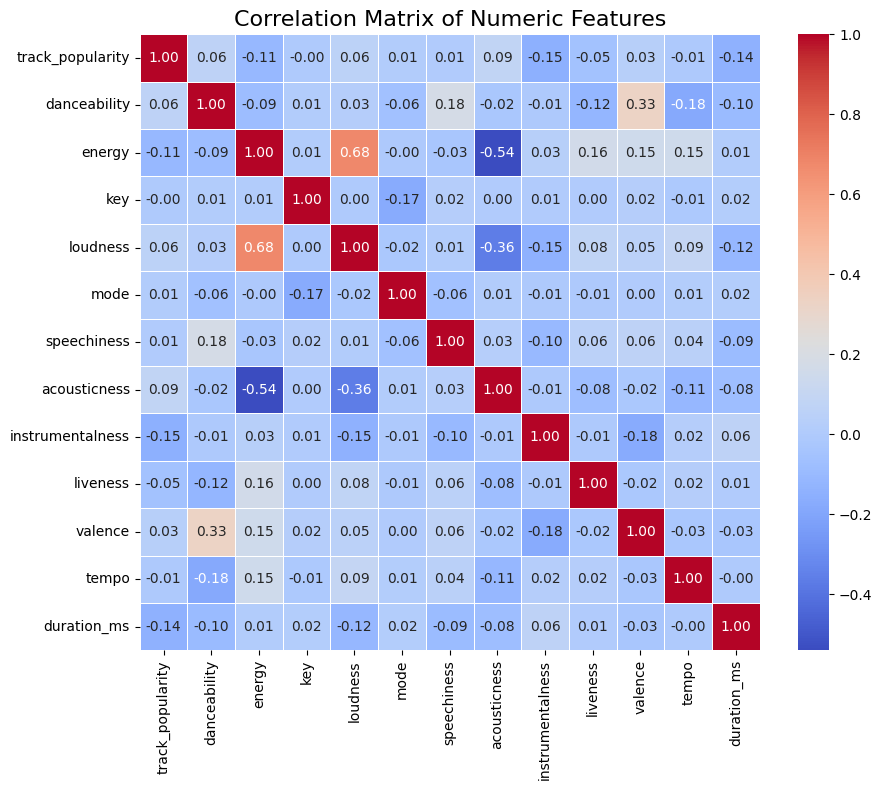

In [ ]:
# Selecting numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculating the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

### I decided to explore the correlation matrix to identify features with strong relationships. The highest correlation was between energy and loudness, so I chose to analyze their relationship.

In [ ]:
X = df[['energy']]
y = df['loudness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Display the intercept (b0) and coefficient (beta)
b0 = model.intercept_
beta = model.coef_[0]

print(f"Intercept (b0): {b0:.2f}")
print(f"Beta (energy): {beta:.2f}\n")

# Make predictions and calculate R²
y_pred = model.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")


Intercept (b0): -14.46
Beta (energy): 11.09

R² Score: 0.4676


### Calculation of Intercept and Coefficients  
## The ${R^2}$ indicates a strong correlation between the features.

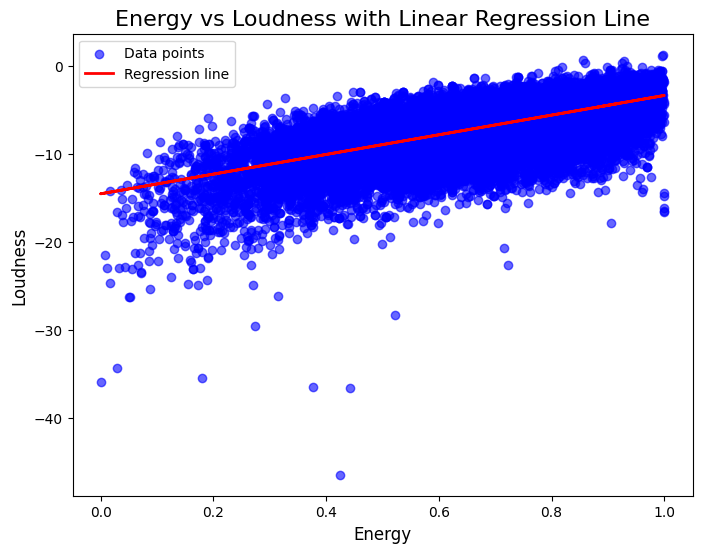

In [ ]:
X = df[['energy']]
y = df['loudness']

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Plotting the scatter plot and the regression line
plt.figure(figsize=(8, 6))

# Scatter plot of the data points
plt.scatter(X, y, color='blue', alpha=0.6, label='Data points')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')
plt.title('Energy vs Loudness with Linear Regression Line', fontsize=16)
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Loudness', fontsize=12)
plt.legend()

# Show the plot
plt.show()


###This scatter plot shows the relationship between Energy and Loudness.  
### There's a clear positive correlation between energy and loudness - as energy increases from 0 to 1, loudness tends to increase from around -15 to -5 decibels. outliers, particularly at very low loudness values (below -25).
### The regression line suggests that while there is a consistent relationship between these two variables, other factors likely influence a song's loudness besides its energy level.

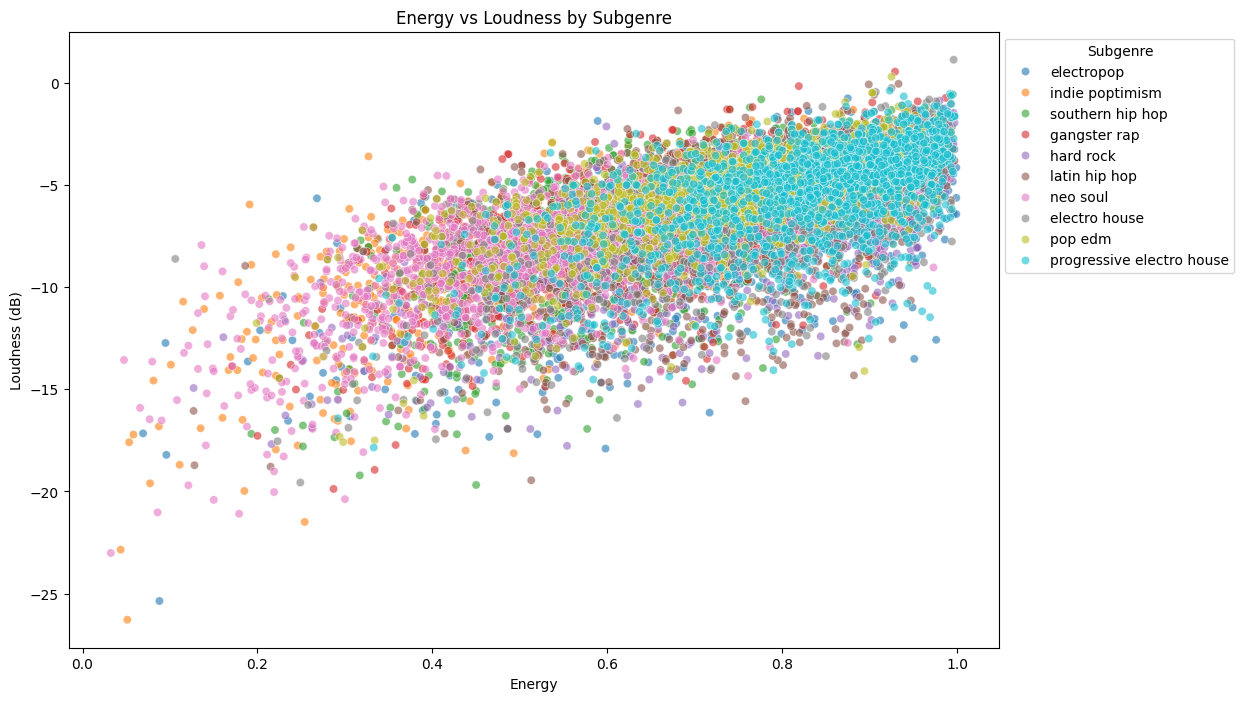

In [10]:
# Ensure the necessary columns exist
df = df[['energy', 'loudness', 'playlist_subgenre']].dropna()

# Get the top 10 most common subgenres (to keep the plot readable)
top_subgenres = df['playlist_subgenre'].value_counts().head(10).index
filtered_df = df[df['playlist_subgenre'].isin(top_subgenres)]

# Plot energy vs. loudness for different subgenres
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_df, x="energy", y="loudness", hue="playlist_subgenre", alpha=0.6, palette="tab10")
plt.title("Energy vs Loudness by Subgenre")
plt.xlabel("Energy")
plt.ylabel("Loudness (dB)")
plt.legend(title="Subgenre", bbox_to_anchor=(1, 1))
plt.show()

### The model visualizes the relationship between Energy and Loudness (dB) across various music subgenres. Each point represents a song, with colors indicating different subgenres. The graph shows a clear positive correlation: as Energy increases, Loudness also tends to increase.

### From the legend, progressive electro house (light blue) appears to dominate the higher-energy and louder spectrum, while subgenres like neo soul (pink) and indie poptimism (orange) are more dispersed in the lower-energy and softer loudness range. The clustering of points suggests that different subgenres have distinct distributions within this space.

playlist_subgenre
tropical           7
electropop         1
indie poptimism    1
hip hop            1
album rock         1
new jack swing     1
Name: count, dtype: int64


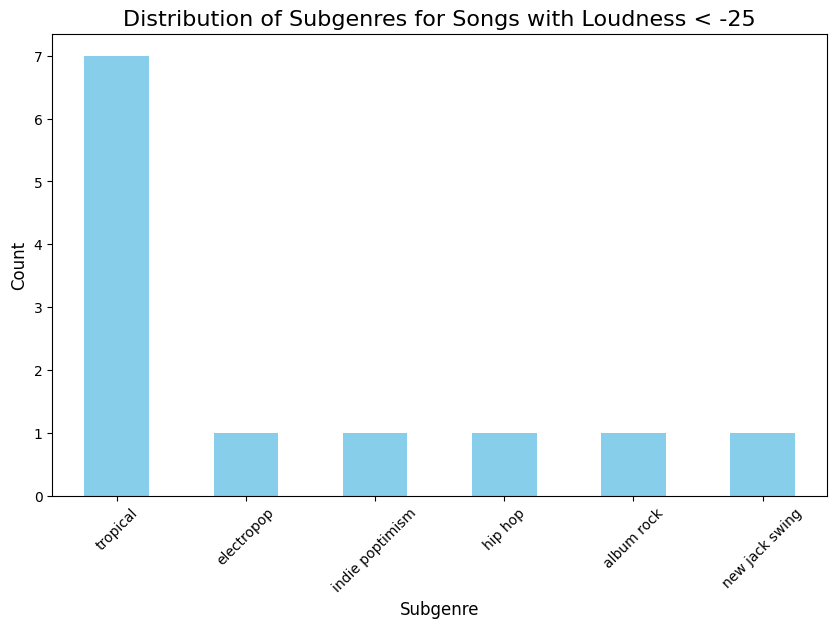

In [ ]:
filtered_df = df[df['loudness'] < -25]
subgenre_counts = filtered_df['playlist_subgenre'].value_counts()
print(subgenre_counts)

plt.figure(figsize=(10, 6))
subgenre_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Subgenres for Songs with Loudness < -25', fontsize=16)
plt.xlabel('Subgenre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### The bar chart shows the distribution of subgenres for songs with loudness below -25 dB, revealing that tropical music dominates this category. This suggests a potential trend where tropical genres maintain high energy despite low loudness, possibly due to unique production techniques. The repeated presence of tropical music in this range indicates it may not be an exception but a stylistic pattern worth further analysis.